# Random Forest Classification of Depression and Gender by Vocal Characteristics
In this project, we will train a Random Forest Classifier to determine whether a participant has depression based on speech data from a clinical interview. The dataset contains 107 participants, 63 of which are male and 44 of which are female. Of these participants, 30 have depression (17 female, 14 male). By varying the weights and features included in the model training, we will demonstrate how differing analysis techniques can have significant impact on the model's classification performance. 

In [1]:
# **** MATH OPERATIONS ****
import numpy as np
import os

# **** DATA MANIPULATION ****
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from scipy import stats


/var/folders/rk/12kwl8cx7x5_r32nqzxl3lq40000gn/T/ipykernel_1618/1388431383.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# general functions
color_dict = {
    'all features': 'mediumpurple',
    'top performing features (depression)': 'darkviolet',
    'top performing features (gender)': 'plum',
    'SBR features': 'indigo',
    'AER features' : 'purple'
}
def load_features(path, labels_df):
    dataframes = []
    
    for file in os.listdir(path):
        if file.split('.')[1] != 'csv':
            continue
        df = pd.read_csv(os.path.join(path, file), header=None)
        participant_id = int(file.split("_")[1].split(".")[0]) # Get ID from file name
        df["Participant_ID"] = participant_id
        dataframes.append(df)
        
    # Combine into a single dataframe
    data_df = pd.concat(dataframes)
    return data_df.merge(labels_df, on="Participant_ID")

def pre_process(train_df, test_df):
    train_df.fillna(train_df.mean(), inplace=True)
    test_df.fillna(test_df.mean(), inplace=True)

    # Exclude the last 3 columns from normalization
    columns_to_normalize = train_df.columns[:-3]

    # Normalize the selected columns using Min-Max scaling
    scaler = StandardScaler()
    train_df_normalized = train_df.copy()
    train_df_normalized[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])

    # Remove outliers based on everything except the last 3 columns
    all_columns_except_last_3 = train_df.columns[:-3]
    z_scores = np.abs(stats.zscore(train_df_normalized[all_columns_except_last_3]))
    threshold = 1.5
    outlier_indices = np.where((z_scores < threshold).all(axis=1))[0]

    # Remove corresponding rows (including last 3 columns) when removing outliers
    train_df_no_outliers = train_df_normalized.drop(outlier_indices)
    test_df_normalized = test_df.copy()
    test_df_normalized[columns_to_normalize] = scaler.fit_transform(test_df[columns_to_normalize])
    return train_df_no_outliers, test_df_normalized

def analyze_results(test_df, display_results=True,  pred_label='Depression', threshold = 0.05):
    # Group by participant and average predictions 
    participant_predictions = test_df.groupby("Participant_ID")['prediction'].mean()

    participant_predictions_binarized = (participant_predictions >= threshold).astype(int)

    # Join aggregated predictions back with the depression labels
    participant_labels = test_df.groupby("Participant_ID")[pred_label].first()

    # Filter data by gender
    male_participants = test_df[test_df["Gender"] == 1]["Participant_ID"].unique()
    female_participants = test_df[test_df["Gender"] == 0]["Participant_ID"].unique()

    # Calculate accuracies for all, male, and female participants
    all_metrics_depression = calculate_accuracy(participant_labels, 
                                                participant_predictions_binarized, "All participants",
                                                display_results=display_results)

    if pred_label == 'Depression':
        if display_results:
            print("")
        male_metrics = calculate_accuracy(participant_labels.loc[male_participants],
                                       participant_predictions_binarized.loc[male_participants], "Male participants",
                                       display_results=display_results)
        if display_results:
            print("")
        female_metrics = calculate_accuracy(participant_labels.loc[female_participants], 
                                        participant_predictions_binarized.loc[female_participants],
                                          "Female participants", display_results=display_results)

        # Calculate EO
        eo = (1 - abs(male_metrics["tpr"] - female_metrics["tpr"]))
        if display_results:
            print(f"Equality of Opportunity (EO): {eo:.2f}")

        return all_metrics_depression, male_metrics, female_metrics, eo
    return all_metrics_depression

def calculate_accuracy(y_true, y_pred, group, display_results=True):
    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate Balanced Accuracy
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    
    # Extract TP, FP, TN, FN
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tpr = tp / (tp + fn) # True Positive Rate
    tnr = tn / (tn + fp) # True Negative Rate
    fpr = fp / (fp + tn) # False Positive Rate
    fnr = fn / (fn + tp) # False Negative Rate
    
    # Store metrics
    metrics = {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "tpr": tpr,
        "tnr": tnr,
        "fpr": fpr,
        "fnr": fnr
    }
    if display_results:
        print(f"Metrics for {group}:")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
        print(f"True Positive Rate (TPR): {tpr:.2f}")
        print(f"True Negative Rate (TNR): {tnr:.2f}")
        print(f"False Positive Rate (FPR): {fpr:.2f}")
        print(f"False Negative Rate (FNR): {fnr:.2f}")
    
    return metrics


def train_random_forest(X, y, group='All'):
    l = len(X)
    X_train = X[:int(0.7*l)]
    y_train = y[:int(0.7*l)]
    X_val = X[int(-0.3*l):]
    y_val = y[int(-0.3*l):]
    n_estimators = [10, 50, 100, 200]
    max_depth = [None, 10, 20, 50]
    best_acc = 0
    best_model = None
    best_param = None

    for n in n_estimators:
        for d in max_depth:
            clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', n_estimators = n, max_depth = d)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            metric = calculate_accuracy(np.array(y_val), y_pred, group, display_results=False)
            if(metric['accuracy'] > best_acc):
                best_acc = metric['accuracy']
                best_model = clf
                best_param = n,d
    return best_acc, best_model, best_param

def manual_confusion_matrix(y_true, y_pred):
    # Initialize counts for true negatives (TN), false positives (FP), 
    # false negatives (FN), and true positives (TP)
    tn = fp = fn = tp = 0
    
    # Iterate over each pair of true and predicted labels
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == 0 and pred_label == 0:
            tn += 1
        elif true_label == 0 and pred_label == 1:
            fp += 1
        elif true_label == 1 and pred_label == 0:
            fn += 1
        elif true_label == 1 and pred_label == 1:
            tp += 1
    
    return tn, fp, fn, tp

def bar_graph(vals:dict, measures:list, title:str):
    x = np.arange(len(measures))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(12, 7))
    for attribute, measurement in vals.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=color_dict[attribute])
        ax.bar_label(rects, padding=5)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.set_xticks(x + width, measures)
    ax.legend(loc='upper left', ncols=4)
    ax.set_ylim(0, 1)
    fig.tight_layout()
    plt.show()

In [3]:
# pull in dataset & labels
labels_df = pd.read_csv("labels.csv")
train_df = load_features("features_train", labels_df)
test_df = load_features("features_test", labels_df)
train_df, test_df = pre_process(train_df, test_df)
# append feature names
features = pd.read_csv('feature_description.csv',
                    encoding = 'ISO-8859-1', 
                    names=['feature', 'description'])['feature'].values.tolist()
col_names = {x:features[x] for x in range(88)}
train_df.rename(columns=col_names, inplace=True)
test_df.rename(columns=col_names, inplace=True)

## Problem (1a) Classification of Gender and Depression
TODO Fill in

In [4]:
X_train = train_df.drop(["Participant_ID", "Depression", "Gender"], axis=1)
y_train_depression = train_df["Depression"]
y_train_gender= train_df["Gender"]


# Apply the same transformation to the test data
X_test = test_df.drop(["Participant_ID", "Depression", "Gender"], axis=1)
y_test_depression = test_df["Depression"]
y_test_gender = test_df["Gender"]

### Problem (a.i) Depression Classification

The model struggled with true positives cases (the depressed individuals), as indicated with a low TPR amongst several groups. This would suggest an issue with sensitivity which is particularly concerning for a diagnostic tool where missing a positive case can have serious consequences

This is an indication of the data having fewer cases of depression than cases of which do not have depression, which we do know is the case of our data, as there are 30 participants with depression out of the total 107 participants.

Thus the model may have become biased towards predicting not depressed, resulting in a low sensitivity towards depression.

Adjusting class weights or using resampling strategies could potenitally improve the model's sensitivity

Utilizing different thresholds than the default 0.5 based on a ROC curve analysis might help increase the TPR wihout excessively effecting other metrics like accuracy.

Reevaluating the features used in the model could provide insights into whether adding additional information or some transformation could improve model predictions. Using feature selection techniques to focus on the most informative attributes could help


In [5]:
best_acc_depression, best_model_depression, best_param_depression = train_random_forest(X_train, y_train_depression)
print('Accuracy:', round(best_acc_depression, 2),' and best parameters: ',best_param_depression)
test_df_temp = test_df.copy()
test_df_temp['prediction']= best_model_depression.predict(X_test)

Accuracy: 0.73  and best parameters:  (200, None)


In [6]:
all_metrics_depression, male_metrics_depression, female_metrics_depression, eo = analyze_results(test_df_temp, pred_label='Depression', threshold=.2)

Metrics for All participants:
Accuracy: 0.70
Balanced Accuracy: 0.60
True Positive Rate (TPR): 0.33
True Negative Rate (TNR): 0.86
False Positive Rate (FPR): 0.14
False Negative Rate (FNR): 0.67

Metrics for Male participants:
Accuracy: 0.83
Balanced Accuracy: 0.45
True Positive Rate (TPR): 0.00
True Negative Rate (TNR): 0.91
False Positive Rate (FPR): 0.09
False Negative Rate (FNR): 1.00

Metrics for Female participants:
Accuracy: 0.50
Balanced Accuracy: 0.53
True Positive Rate (TPR): 0.40
True Negative Rate (TNR): 0.67
False Positive Rate (FPR): 0.33
False Negative Rate (FNR): 0.60
Equality of Opportunity (EO): 0.60


### Problem (a.ii) Gender Classification


At the default threshold, the model achieved perfect scores in accuracy, balanced accuracy, TPR, and TNR for gender classificationl While this may initially suggest excellent model performance, it also raises questions about overfitting or the presense of features that may be extremely indicative of the outcome.

Having features strongly correlated to gender may have influenced this models ability to achieve these perfect scores.

But given these perfect metrics, it's important to ensure that the model is not overfitting the training data. We could use cross-validation to help verify the model's robustness across different subsets of the data. It is also important to make sure there is no access to data leakage, such as failing to remove the actual gender classifying data, although we did ensure that was the case with this model.



In [7]:
best_acc_gender, best_model_gender, best_param_gender = train_random_forest(X_train, y_train_gender)
print('Accuracy:', round(best_acc_gender, 2),' and best parameters: ', best_param_gender)
test_df_temp = test_df.copy()
test_df_temp['prediction'] = best_model_gender.predict(X_test)


Accuracy: 0.89  and best parameters:  (100, 10)


In [8]:
x = 10
all_metrics_gender = analyze_results(test_df_temp, pred_label='Gender', threshold=.2)

Metrics for All participants:
Accuracy: 0.85
Balanced Accuracy: 0.81
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.62
False Positive Rate (FPR): 0.38
False Negative Rate (FNR): 0.00


## Problem (1b) Depression Feature Selection
In this section, we will repeat the same depression classification as above on only the features with the strongest correlation with depression.

In [9]:
# perform depression classification on the data
correlation_tups = []
for col in train_df.columns:
    if col in ['Participant_ID', 'Depression']:
        continue
    correlation_tups.append((col, train_df[col].corr(train_df['Depression'])))
correlation_tups = sorted(correlation_tups, key=lambda x: abs(x[1]), reverse=True)
top_twenty_feats = {correlation_tups[x][0]:round(correlation_tups[x][1], 3)  for x in range(20)}
print('Top twenty features correlated with depression: \n')
for key, val in top_twenty_feats.items():
    print(f'{key}: {val}')

Top twenty features correlated with depression: 

loudness_sma3_pctlrange0-2: 0.199
loudness_sma3_percentile80.0: 0.197
loudness_sma3_amean: 0.192
loudness_sma3_percentile50.0: 0.162
spectralFluxV_sma3nz_amean: 0.155
spectralFlux_sma3_amean: 0.137
loudness_sma3_meanRisingSlope: 0.136
loudness_sma3_meanFallingSlope: 0.124
HNRdBACF_sma3nz_amean: 0.116
F0semitoneFrom27.5Hz_sma3nz_percentile50.0: 0.115
loudness_sma3_stddevRisingSlope: 0.114
equivalentSoundLevel_dBp: 0.114
F0semitoneFrom27.5Hz_sma3nz_percentile20.0: 0.112
F0semitoneFrom27.5Hz_sma3nz_amean: 0.111
loudness_sma3_stddevFallingSlope: 0.109
F0semitoneFrom27.5Hz_sma3nz_percentile80.0: 0.109
loudness_sma3_percentile20.0: 0.099
spectralFluxV_sma3nz_stddevNorm: 0.097
Gender: -0.097
F1frequency_sma3nz_amean: 0.081


The participants with depression more frequently spoke loudly (loudness_sma3) and with more fluctuations (spectralFlux). There is also slight correlation between the vocal range (semitone) and the speaker's depression. Since the majority of participants with depression were female, there is a correlation between gender and depression, as well.

We will now train a Random Forest Classifier to predict depression using only the features most strongly correlated with depression. 

In [10]:
features = [correlation_tups[x][0] for x in range(5)]
filtered_df = X_train.loc[:, features]
filtered_test = X_test.loc[:, features]
filtered_test.head()

,loudness_sma3_pctlrange0-2,loudness_sma3_percentile80.0,loudness_sma3_amean,loudness_sma3_percentile50.0,spectralFluxV_sma3nz_amean
0,-0.675974,-0.725252,-0.697076,-0.384915,-0.519358
1,-0.401680,-0.182080,-0.101978,-0.073909,0.018555
2,-0.191265,-0.337158,-0.197889,-0.307052,-0.236540
3,-0.163767,-0.047027,0.039224,0.122366,-0.195008
4,-0.418077,-0.132925,0.031930,0.243504,-0.382822


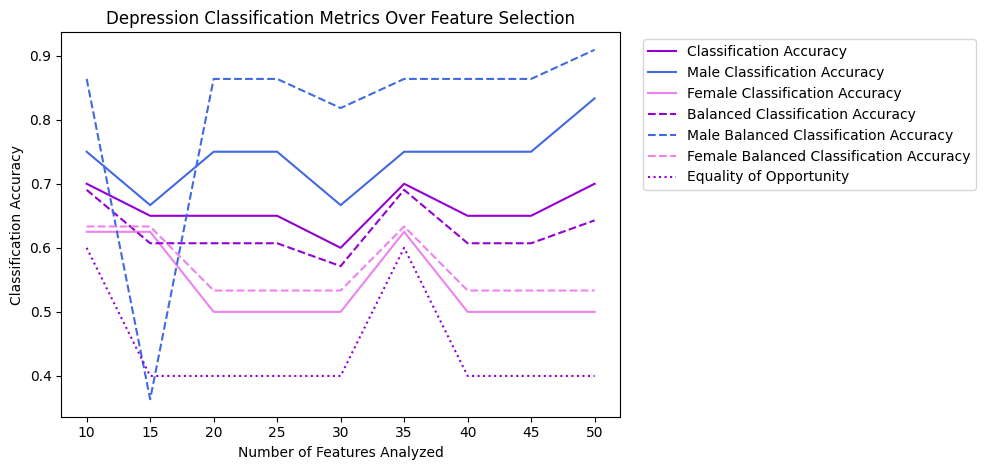

In [11]:
# add gender label back in
X_train_dep = X_train.copy()
X_train_dep['Gender'] = y_train_gender
X_test_dep = X_test.copy()
X_test_dep['Gender'] = y_test_gender
# run model on filtered features
class_acc_dep_fs, bca_dep_fs, male_class_acc_dep_fs, male_bca_dep_fs, female_class_acc_dep_fs, female_bca_dep_fs, eo_dep_fs = [],[],[],[],[], [], []
for n in range(10, 51, 5):
    # select top performing features
    features = [correlation_tups[x][0] for x in range(n)]
    filtered_df = X_train_dep.loc[:, features]
    # build random forest on these features
    best_acc, best_rand_forest, best_params = train_random_forest(filtered_df, y_train_depression)
    filtered_test = X_test_dep.loc[:, features]
    predictions = best_rand_forest.predict(filtered_test)
    # store accuracies
    test_df_pred = test_df.copy()
    test_df_pred['prediction'] = predictions
    all_res, male_res, female_res, eo_res = analyze_results(test_df_pred,  
                                                            threshold=.2,
                                                            display_results=False)
    class_acc_dep_fs.append(all_res['accuracy'])
    bca_dep_fs.append(all_res['balanced_accuracy'])
    male_class_acc_dep_fs.append(male_res['accuracy'])
    male_bca_dep_fs.append(male_res['balanced_accuracy'])
    female_class_acc_dep_fs.append(female_res['accuracy'])
    female_bca_dep_fs.append(female_res['balanced_accuracy'])
    eo_dep_fs.append(eo_res)


# plot results
fig, ax = plt.subplots(1, 1)
num_feats = range(10, 51, 5)
ax.plot(num_feats, class_acc_dep_fs, label = "Classification Accuracy", color='darkviolet') 
ax.plot(num_feats, male_class_acc_dep_fs, label = "Male Classification Accuracy", color='royalblue') 
ax.plot(num_feats, female_class_acc_dep_fs, label = "Female Classification Accuracy", color='violet') 
ax.plot(num_feats, bca_dep_fs, label = "Balanced Classification Accuracy", color='darkviolet', linestyle='dashed') 
ax.plot(num_feats, male_bca_dep_fs, label = "Male Balanced Classification Accuracy", color='royalblue', linestyle='dashed') 
ax.plot(num_feats, female_bca_dep_fs, label = "Female Balanced Classification Accuracy", color='violet', linestyle='dashed') 
ax.plot(num_feats, eo_dep_fs, label = "Equality of Opportunity", color='darkviolet', linestyle='dotted')
ax.set_title('Depression Classification Metrics Over Feature Selection')
ax.set_xlabel('Number of Features Analyzed')
ax.set_ylabel('Classification Accuracy')
fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.5, 0.5, 0.5)) 
plt.show()

The above plot shows the depression classification accuracy measures over male and female participants as the number of features included in the model increase. With minimal (10) features included in the model training, the Random Forest Classifier has its highest performance on female participants. As more features (with decreasing correlation) increase, the classification accuracy on male participants increases, while the classification accuracy on female participants decreases. 

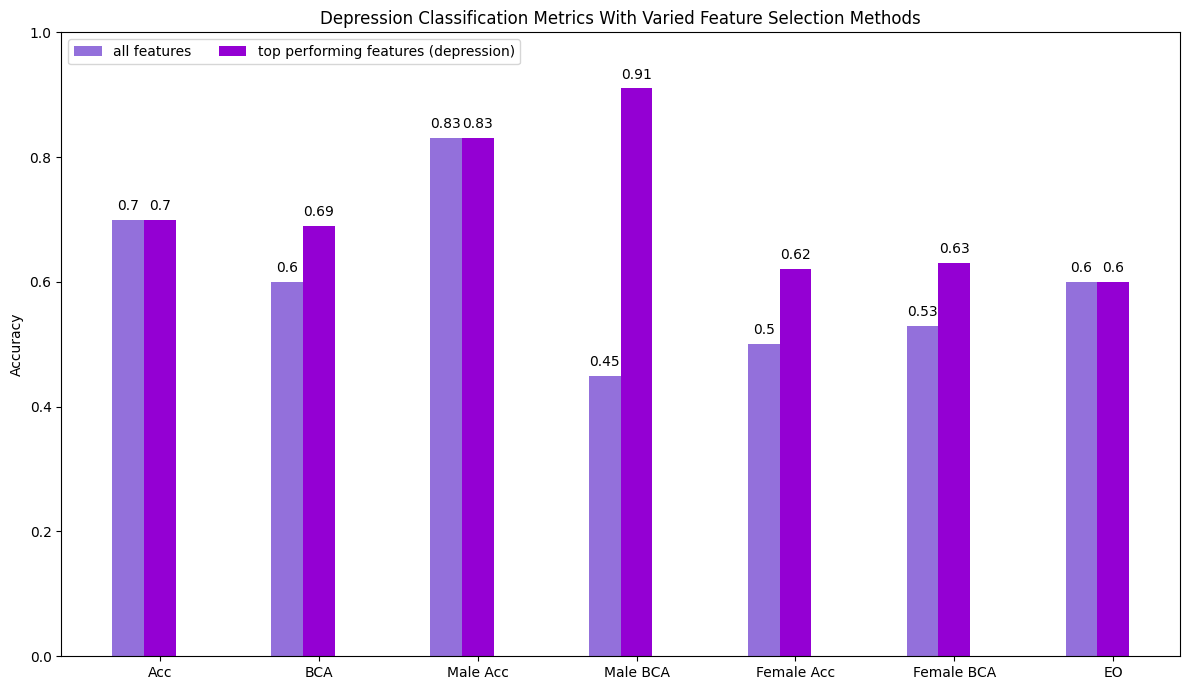

In [12]:
best_ind = bca_dep_fs.index(max(bca_dep_fs))
best_male_ind = male_bca_dep_fs.index(max(male_bca_dep_fs))
best_female_ind = female_bca_dep_fs.index(max(female_bca_dep_fs))
measures = ['Acc', 'BCA', 'Male Acc', 'Male BCA', 'Female Acc', 'Female BCA', 'EO']
all_metrics_depression = {x:round(y, 2) for x,y in all_metrics_depression.items()}
male_metrics = {x:round(y, 2) for x,y in male_metrics_depression.items()}
female_metrics = {x:round(y, 2) for x,y in female_metrics_depression.items()}
class_acc = [round(x, 2) for x in class_acc_dep_fs]
male_class_acc = [round(x, 2) for x in male_class_acc_dep_fs]
female_class_acc = [round(x, 2) for x in female_class_acc_dep_fs]
bca = [round(x, 2) for x in bca_dep_fs]
male_bca = [round(x, 2) for x in male_bca_dep_fs]
female_bca = [round(x, 2) for x in female_bca_dep_fs]
vals = {
    'all features': [all_metrics_depression['accuracy'], all_metrics_depression['balanced_accuracy'], 
                     male_metrics['accuracy'], male_metrics['balanced_accuracy'], 
                     female_metrics['accuracy'], female_metrics['balanced_accuracy'], .6],
    'top performing features (depression)': [class_acc[best_ind], bca[best_ind], 
                          male_class_acc[best_male_ind], male_bca[best_male_ind],
                          female_class_acc[best_female_ind], female_bca[best_female_ind], eo_dep_fs[best_ind]],     
}
bar_graph(vals, measures, 'Depression Classification Metrics With Varied Feature Selection Methods')

The balanced classification accuracy sees a slight change from the best performing feature-selection model to the original model. The overall classification accuracy remains unchanged. 
While the feature selection model increases accuracies for both male and female participants, there is a greater difference in the performance by gender than in the original model.
The original model performs better on classifying the female participants, with a 5% difference in the balanced classificaiton accuracy. However, the feature-selection model performs better on classifying male participants, with a 27% difference in the balanced classification accuracy. 

### Problem (1c) Gender Feature Selection


In [13]:
features = pd.read_csv('feature_description.csv',
                    encoding = 'ISO-8859-1')

In [14]:
column_name_features = features.columns

In [15]:
features.rename(columns={column_name_features[0]: 'Features', column_name_features[1]: 'Description'}, inplace=True)


In [16]:
features.head()

,Features,Description
0,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,standard deviation of logarithmic F0 on a semi...
1,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,20th percentile of logarithmic F0 on a semiton...
2,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,50th percentile of logarithmic F0 on a semiton...
3,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,80th percentile of logarithmic F0 on a semiton...
4,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,range of 20th to 80th percentile of logarithmi...


In [17]:
column_name_features = features.columns

In [18]:
i = 20  # Number of features
X_train_mod = X_train.values
correlations = [abs(pearsonr(X_train_mod[:, j], y_train_gender)[0]) for j in range(X_train.shape[1])]
top_feature_indices = sorted(range(len(correlations)), key=lambda j: correlations[j], reverse=True)[:i]
X_train_selected = X_train_mod[:, top_feature_indices]


In [19]:
features.head()

,Features,Description
0,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,standard deviation of logarithmic F0 on a semi...
1,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,20th percentile of logarithmic F0 on a semiton...
2,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,50th percentile of logarithmic F0 on a semiton...
3,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,80th percentile of logarithmic F0 on a semiton...
4,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,range of 20th to 80th percentile of logarithmi...


In [20]:
feature_names = features['Features'].tolist()
descriptions = features['Description'].tolist()

In [21]:
def find_best_features(X, y, best_prams):
    l = len(X)
    X_train = X[:int(0.7*l)]
    X_train = X_train.values
    y_train = y[:int(0.7*l)]
    X_val = X[int(-0.3*l):]
    X_val = X_val.values
    y_val = y[int(-0.3*l):]
    clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', n_estimators = best_prams[0], max_depth = best_prams[1])

    # Declare range
    num_features = range(5, 31, 5)
    result = []
    correlations = [abs(pearsonr(X_train[:, i], y_train)[0]) for i in range(X_train.shape[1])]

    for num in num_features:
        top_feature_indices = sorted(range(len(correlations)), key=lambda i: correlations[i], reverse=True)[:num]
        X_train_selected = X_train[:, top_feature_indices]
        X_val_selected = X_val[:, top_feature_indices]
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_val_selected)
        metrics = calculate_accuracy(y_val, y_pred, False)
        result.append({'model':clf, 'indices':top_feature_indices,'Number of Features': num, 'Accuracy':metrics['accuracy']})
    return result, correlations
    

In [22]:
result_gender, correlations_gender = find_best_features(X_train, y_train_gender, best_param_gender)

Metrics for False:
Accuracy: 0.88
Balanced Accuracy: 0.86
True Positive Rate (TPR): 0.97
True Negative Rate (TNR): 0.76
False Positive Rate (FPR): 0.24
False Negative Rate (FNR): 0.03
Metrics for False:
Accuracy: 0.87
Balanced Accuracy: 0.85
True Positive Rate (TPR): 0.95
True Negative Rate (TNR): 0.76
False Positive Rate (FPR): 0.24
False Negative Rate (FNR): 0.05
Metrics for False:
Accuracy: 0.89
Balanced Accuracy: 0.87
True Positive Rate (TPR): 0.96
True Negative Rate (TNR): 0.78
False Positive Rate (FPR): 0.22
False Negative Rate (FNR): 0.04
Metrics for False:
Accuracy: 0.89
Balanced Accuracy: 0.87
True Positive Rate (TPR): 0.96
True Negative Rate (TNR): 0.78
False Positive Rate (FPR): 0.22
False Negative Rate (FNR): 0.04
Metrics for False:
Accuracy: 0.90
Balanced Accuracy: 0.88
True Positive Rate (TPR): 0.96
True Negative Rate (TNR): 0.80
False Positive Rate (FPR): 0.20
False Negative Rate (FNR): 0.04
Metrics for False:
Accuracy: 0.90
Balanced Accuracy: 0.88
True Positive Rate (TP

In [23]:
best_acc_filtered_gender = 0
n_best  = None
top_feature_df_gender_list = []
for n in result_gender:
    if(n['Accuracy'] > best_acc_filtered_gender):
        best_acc_filtered_gender = n['Accuracy']
        n_best = n
    top_feature_df_gender_list.append({'Number of Features': n['Number of Features'], 'Accuracy':n['Accuracy']})
    print("Number of features: ", n['Number of Features']," gave accuracy of: ", n['Accuracy'])
top_feature_df_gender = pd.DataFrame(top_feature_df_gender_list)

Number of features:  5  gave accuracy of:  0.8843537414965986
Number of features:  10  gave accuracy of:  0.8744331065759637
Number of features:  15  gave accuracy of:  0.8866213151927438
Number of features:  20  gave accuracy of:  0.8886054421768708
Number of features:  25  gave accuracy of:  0.8971088435374149
Number of features:  30  gave accuracy of:  0.8971088435374149


In [24]:
top_feature_df_gender.head()

,Number of Features,Accuracy
0,5,0.884354
1,10,0.874433
2,15,0.886621
3,20,0.888605
4,25,0.897109


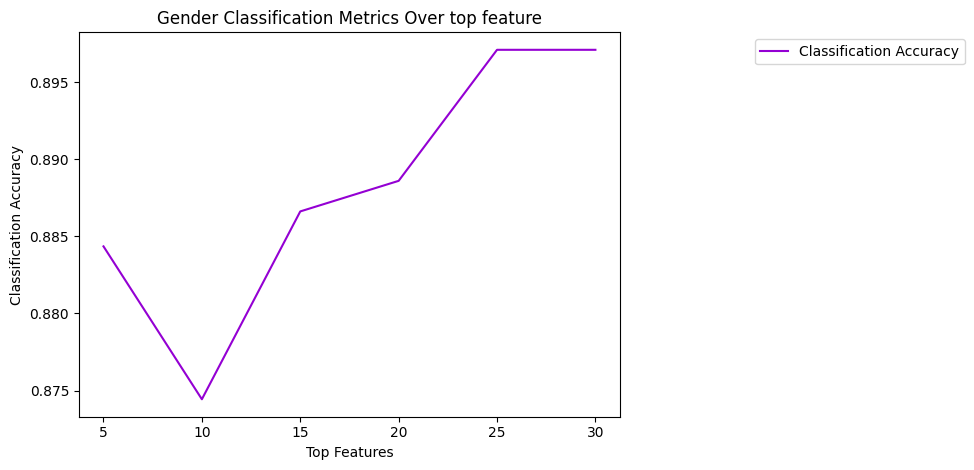

In [25]:
# plot results
fig, ax = plt.subplots(1, 1)
num_top_features = range(5, 31, 5)
ax.plot(num_top_features, top_feature_df_gender['Accuracy'], label = "Classification Accuracy", color='darkviolet') 
ax.set_title('Gender Classification Metrics Over top feature')
ax.set_xlabel('Top Features')
ax.set_ylabel('Classification Accuracy')
fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.5, 0.5, 0.5)) 
plt.show()

#### Finding the most informative features for gender

In [26]:
top_feature_names = [feature_names[index] for index in result_gender[3]['indices']]
top_description = [descriptions[index] for index in result_gender[3]['indices']]

# Create a DataFrame with feature names and their corresponding correlations
correlation_df = pd.DataFrame({
    'Feature': top_feature_names,
    'Feature Description': top_description,
    'Correlation': [correlations[index] for index in result_gender[3]['indices']]
})

correlation_df

,Feature,Feature Description,Correlation
0,HNRdBACF_sma3nz_stddevNorm,standard deviation of Harmonics-to-Noise Ratio...,0.616603
1,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,50th percentile of logarithmic F0 on a semiton...,0.569876
2,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,80th percentile of logarithmic F0 on a semiton...,0.571997
3,slopeV0-500_sma3nz_stddevNorm,standard deviation of spectral slope from 0Ð50...,0.560016
4,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,standard deviation of logarithmic F0 on a semi...,0.561701
5,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,range of 20th to 80th percentile of logarithmi...,0.547992
6,mfcc4V_sma3nz_stddevNorm,standard deviation of the fourth Mel-Frequency...,0.409428
7,mfcc4_sma3_stddevNorm,standard deviation of the fourth Mel-Frequency...,0.388414
8,shimmerLocaldB_sma3nz_amean,mean shimmer,0.324747
9,HNRdBACF_sma3nz_amean,mean Harmonics-to-Noise Ratio (HNR),0.247190


In [27]:
X_test_temp = X_test.values
test_df_temp = test_df.copy()
test_df_temp['prediction']= n_best['model'].predict(X_test_temp[:,n['indices']])

In [28]:
filtered_metric_gender = analyze_results(test_df_temp, False, 'Gender' ,0.2)

### Problem (1d) Mitigating Bias Via Removing Gender-Dependent Features


In [29]:
# sample based reweight

samples_per_gender = train_df['Gender'].value_counts()
total_samples = len(train_df)
inverse_representation = total_samples / samples_per_gender
print(samples_per_gender)

train_df_weights = train_df.copy()
train_df_weights['weights'] = train_df['Gender'].map(inverse_representation)
reweights = train_df_weights['weights']

Gender
1    6873
0    4889
Name: count, dtype: int64


In [30]:
model_sbr = RandomForestClassifier(random_state=42, class_weight='balanced')
model_sbr.fit(X_train, y_train_depression, sample_weight=reweights)

test_df_temp = test_df.copy()
test_df_temp['prediction']= model_sbr.predict(X_test)
all_sbr, male_sbr, female_sbr, eo_sbr = analyze_results(test_df_temp, False, 'Depression' ,0.2)

In [31]:
filtered_metric_gender

{'accuracy': 0.85,
 'balanced_accuracy': 0.8125,
 'tpr': 1.0,
 'tnr': 0.625,
 'fpr': 0.375,
 'fnr': 0.0}

In [32]:
def get_filtered_results(X_train, y_train, X_test, y_test, result, best_param, df):
    X_train_temp = X_train.values
    X_test_temp = X_test.values
    clf_filtered = RandomForestClassifier(random_state = 42, class_weight = 'balanced', n_estimators = best_param_depression[0], max_depth = best_param_depression[1])
    results_df = pd.DataFrame(columns=['accuracy', 'ba_accuracy', 'male_accuracy', 'ba_male_accuracy', 'female_accuracy', 'ba_female_accuracy'])
    results_list = []
    for n in result:
        print("Training with number of features removed: ", n['Number of Features'])
        X_train_filtered = X_train_temp[:, ~np.isin(np.arange(X_train_temp.shape[1]), n['indices'])]
        print(X_train_filtered.shape)
        X_test_filtered = X_test_temp[:, ~np.isin(np.arange(X_test_temp.shape[1]), n['indices'])]
        clf_filtered.fit(X_train_filtered, y_train)
        df['prediction'] = clf_filtered.predict(X_test_filtered)
        # depreesion_metric  = calculate_accuracy(y_test, y_pred)
        depreesion_metric, male_metric, female_metric, eo = analyze_results(df, False,'Depression',0.2)
        eo = (1 - abs(male_metric["tpr"] - female_metric["tpr"]))
        results_list.append({
            'accuracy': depreesion_metric['accuracy'],
            'male_accuracy': male_metric['accuracy'],
            'female_accuracy':female_metric['accuracy'],
            'ba_accuracy': depreesion_metric['balanced_accuracy'],
            'ba_male_accuracy': male_metric['balanced_accuracy'],
            'ba_female_accuracy':female_metric['balanced_accuracy'],
            'eo': eo
        })
    results_df = pd.DataFrame(results_list)
    return results_df

In [33]:
result_dffiletered = get_filtered_results(X_train, y_train_depression, X_test, y_test_depression, result_gender, best_param_depression, test_df_temp)

Training with number of features removed:  5
(11762, 83)
Training with number of features removed:  10
(11762, 78)
Training with number of features removed:  15
(11762, 73)
Training with number of features removed:  20
(11762, 68)
Training with number of features removed:  25
(11762, 63)
Training with number of features removed:  30
(11762, 58)


In [34]:
result_dffiletered

,accuracy,male_accuracy,female_accuracy,ba_accuracy,ba_male_accuracy,ba_female_accuracy,eo
0,0.65,0.833333,0.375,0.464286,0.454545,0.5,1.0
1,0.65,0.833333,0.375,0.464286,0.454545,0.5,1.0
2,0.65,0.833333,0.375,0.464286,0.454545,0.5,1.0
3,0.65,0.833333,0.375,0.464286,0.454545,0.5,1.0
4,0.65,0.833333,0.375,0.464286,0.454545,0.5,1.0
5,0.65,0.833333,0.375,0.464286,0.454545,0.5,1.0


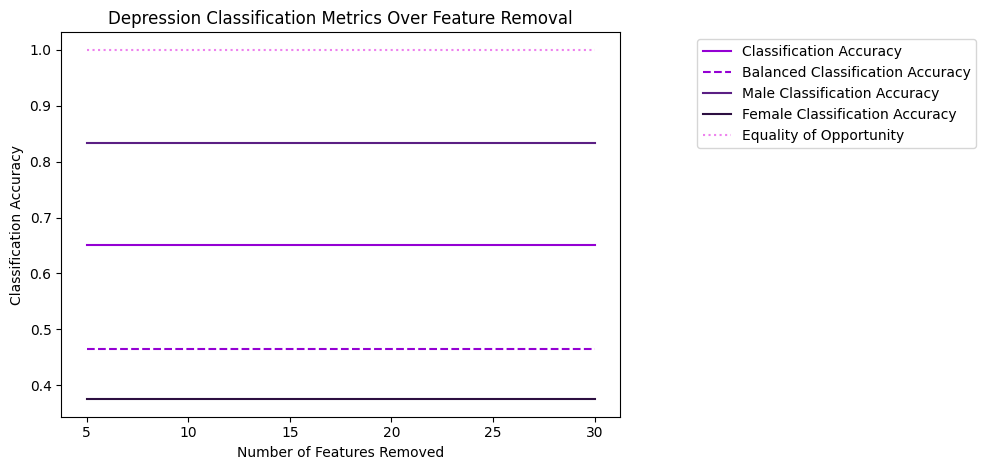

In [35]:
# plot results
fig, ax = plt.subplots(1, 1)
num_feats_removed = range(5, 31, 5)
ax.plot(num_feats_removed, result_dffiletered['accuracy'], label = "Classification Accuracy", color='darkviolet') 
ax.plot(num_feats_removed, result_dffiletered['ba_accuracy'], label = "Balanced Classification Accuracy", color='darkviolet', linestyle='dashed') 
ax.plot(num_feats_removed, result_dffiletered['male_accuracy'], label = "Male Classification Accuracy", color='#5B1F84') 
ax.plot(num_feats_removed, result_dffiletered['female_accuracy'], label = "Female Classification Accuracy", color='#2D0F41') 
ax.plot(num_feats_removed, result_dffiletered['eo'], label = "Equality of Opportunity", color='violet', linestyle='dotted')
ax.set_title('Depression Classification Metrics Over Feature Removal')
ax.set_xlabel('Number of Features Removed')
ax.set_ylabel('Classification Accuracy')
fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.5, 0.5, 0.5)) 
plt.show()

From above we can see that, Classification accuracy for depression varies only slightly after removing the features in start but improves once hits the mark of 25. This indicatese that gender bias features skewed result towards one gender, and by removing those accuracy as well as EO improved.

### Problem (1e) Mitigating Bias Via Other Approaches

#### Mitigating Bias via reweighting
Reweight the samples between female and male speakers by computing the proportion of two classes, and also by applying 'balanced' class weight for random forest classifier.

#### Mitigating bias via autoencoder
Implement autoencoder by training a m
ulti-task neural network. Through the training, compute the loss for gender and depression, and try to decrease the loss of depression prediction while increasing the loss of gender prediction, which will make sure the output features will represent depression well but gender badly. To achieve that, use the negative value of binary cross entropy of gender prediction. After training, take the output as the transformed features.

In [36]:
# auto-encoder 

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

input_layer = Input(shape=(88,))
encoded = Dense(44, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
decoded = Dense(88, activation='sigmoid', name='decoded')(encoded)

gender_output = Dense(1, activation='sigmoid', name='gender')(encoded)
depression_output = Dense(1, name='depression')(encoded)

autoencoder = Model(inputs=input_layer, outputs=[decoded, gender_output, depression_output])

def negative_binary_crossentropy(y_true, y_pred):
    return -tf.keras.losses.binary_crossentropy(y_true, y_pred)
def mean_squared_error(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)
losses = {
    'decoded': mean_squared_error,
    'gender': negative_binary_crossentropy,
    'depression': mean_squared_error,
}

autoencoder.compile(optimizer='adam', loss=losses)

autoencoder.fit(X_train, [X_train, y_train_gender, y_train_depression], epochs=10, batch_size=32)
X_train_encoded = autoencoder.predict(X_train)[0]

Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - loss: -4.5803
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: -112.3129
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: -386.1259
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: -812.0751
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: -1381.6039
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: -2031.1003
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: -2822.0869
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: -3743.9802
Epoch 9/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: -4627.4727
Epoch 10/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: -5725.1924
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


In [37]:
model_aer = RandomForestClassifier(random_state=42, class_weight='balanced')
model_aer.fit(X_train_encoded, y_train_depression)
test_df_temp = test_df.copy()
test_df_temp['prediction']= model_aer.predict(X_test)
all_aer, male_aer, female_aer, eo_aer = analyze_results(test_df_temp, 'Depression', threshold=.2)

Metrics for All participants:
Accuracy: 0.70
Balanced Accuracy: 0.50
True Positive Rate (TPR): 0.00
True Negative Rate (TNR): 1.00
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 1.00

Metrics for Male participants:
Accuracy: 0.92
Balanced Accuracy: 0.50
True Positive Rate (TPR): 0.00
True Negative Rate (TNR): 1.00
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 1.00

Metrics for Female participants:
Accuracy: 0.38
Balanced Accuracy: 0.50
True Positive Rate (TPR): 0.00
True Negative Rate (TNR): 1.00
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 1.00
Equality of Opportunity (EO): 1.00


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


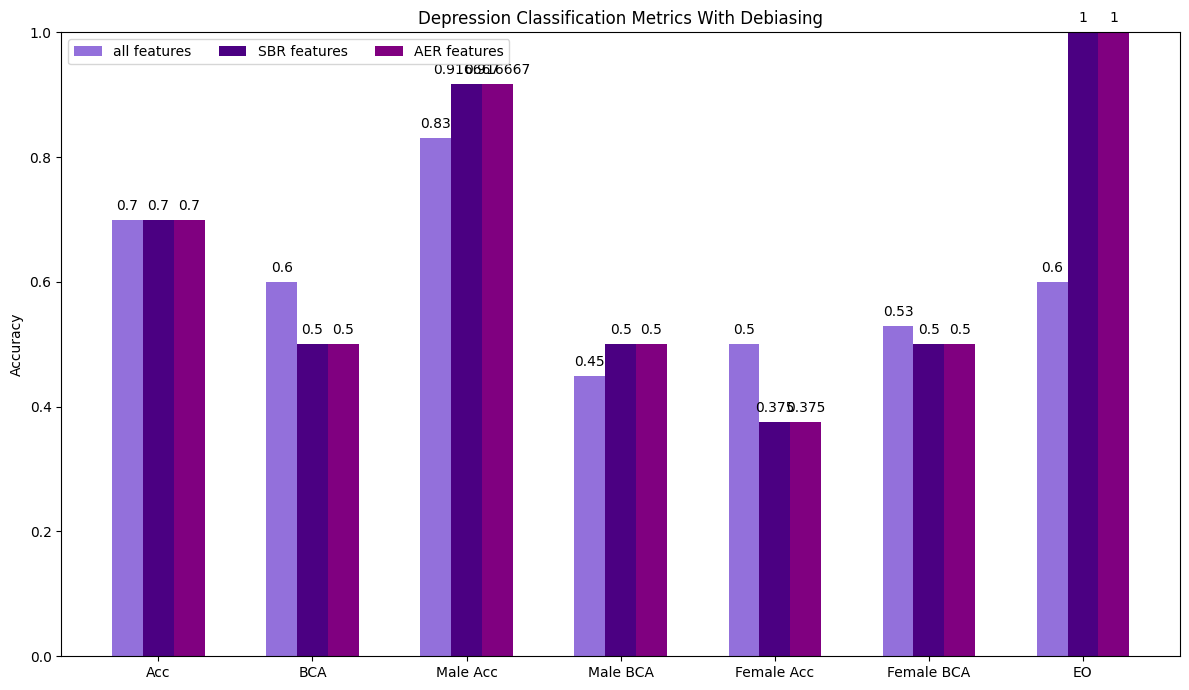

In [38]:
vals = {
    'all features': [all_metrics_depression['accuracy'], all_metrics_depression['balanced_accuracy'], 
                     male_metrics['accuracy'], male_metrics['balanced_accuracy'], 
                     female_metrics['accuracy'], female_metrics['balanced_accuracy'], .6],
    'SBR features': [all_sbr['accuracy'], all_sbr['balanced_accuracy'], 
                     male_sbr['accuracy'], male_sbr['balanced_accuracy'], 
                     female_sbr['accuracy'], female_sbr['balanced_accuracy'], eo_sbr],
    'AER features': [all_aer['accuracy'], all_aer['balanced_accuracy'], 
                 male_aer['accuracy'], male_aer['balanced_accuracy'], 
                 female_aer['accuracy'], female_aer['balanced_accuracy'], eo_aer]
}
bar_graph(vals, measures, 'Depression Classification Metrics With Debiasing')

According to the graph, mitigating bias will reduce the accuracy and balanced accuracy of the model. This might be because the model is trained on imbalanced value, so it can get high accuracy by simply predicting the class which has more samples. The accuracy and balanced accuracy on male class, which has more samples, is somehow increased, whereas accuracy and balanced accuracy on female class is decreased. Moreover, the performance of using autoencoder will mostly depend on how well the autoencoder is trained, as in this task, where the autoencoder struggles with reducing losses stably, the final performance changes a lot.  
One interesting thing to notice is that after mitigating bias, the EO could reach to 1, which indicates it works to some degree.